In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

sns.set()

### 데이터셋 준비

In [2]:
# ETF 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
data = data.droplevel(0, axis=1).resample('W').last()

[*********************100%***********************]  9 of 9 completed


In [3]:
# 수익률
rets = data.pct_change().fillna(0)

In [5]:
# 색깔 팔레트
pal = sns.color_palette('Spectral', len(tickers))

### 동일 비중 포트폴리오

<Axes: xlabel='Date'>

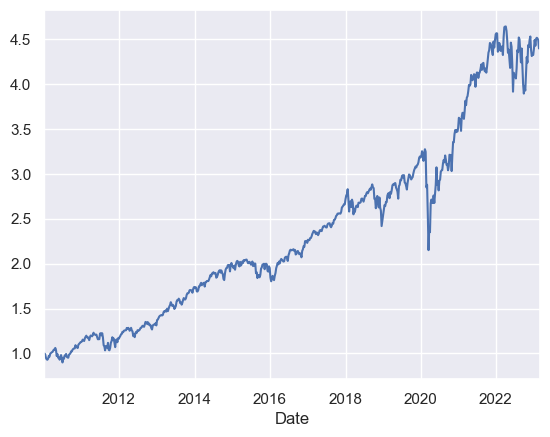

In [10]:
# 동일 비중 포트폴리오 수익률
port_rets = rets.mean(axis=1)

# 백테스팅 수익률
(1 + port_rets).cumprod().plot()

### CVaR 타게팅 모벨

In [12]:
# CVaR 계산 함수
def calculate_CVaR(rets, delta=0.01):
    # delta = 0.01 -> 99% CVaR 계산 의미

    # 수익률을 줄 세운 다음에 하위 1% 값 = VaR
    VaR = rets.quantile(delta)

    # 수익률 중에서 VaR 값보다 낮은 수익률의 평균값 = CVaR
    return rets[rets <= VaR].mean()     # <<-- CVaR

# 1년 롤링 CVaR 계산
lookback = 52

# apply 함수에 calculate_CVaR 함수 적용
# CVaR가 보통 양수로 나오기 때문에 negative로 변경
rolling_CVaR = -port_rets.rolling(lookback).apply(calculate_CVaR).fillna(0)

# 타겟 CVaR
target_CVaR = 0.05

In [16]:
# CVaR 타게팅 하의 포트폴리오 투자 비중
## rolling CVaR이 0인 경우가 있어서 무한대인 경우 0으로 대체
cvt_weights = (target_CVaR / rolling_CVaR).replace([np.inf, -np.inf], 0).fillna(0)

# 레버리지 사용 불가
cvt_weights[cvt_weights > 1] = 1

# CVaR 타게팅 포트폴리오 수익률
cvt_rets = (port_rets * cvt_weights.shift()).fillna(0)
cvt_cum_rets = (1 + cvt_rets).cumprod()

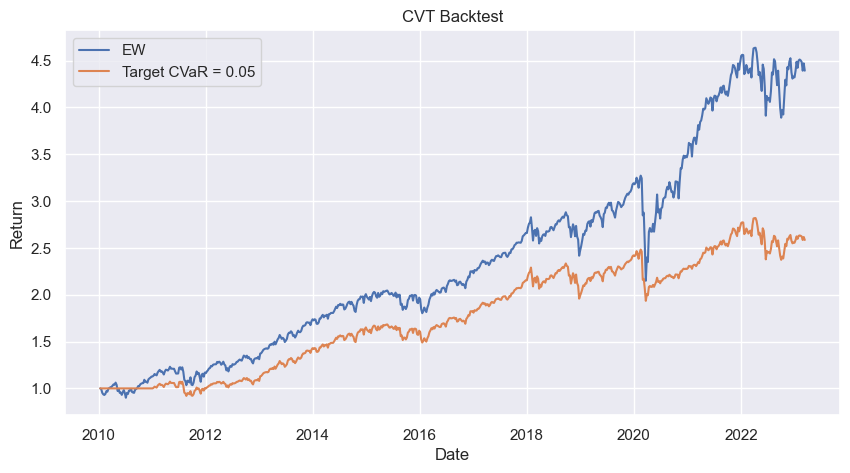

In [17]:
# 백테스팅 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot((1 + port_rets).cumprod(), label='EW')
plt.plot(cvt_cum_rets, label=f'Target CVaR = {target_CVaR}')
plt.title('CVT Backtest')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

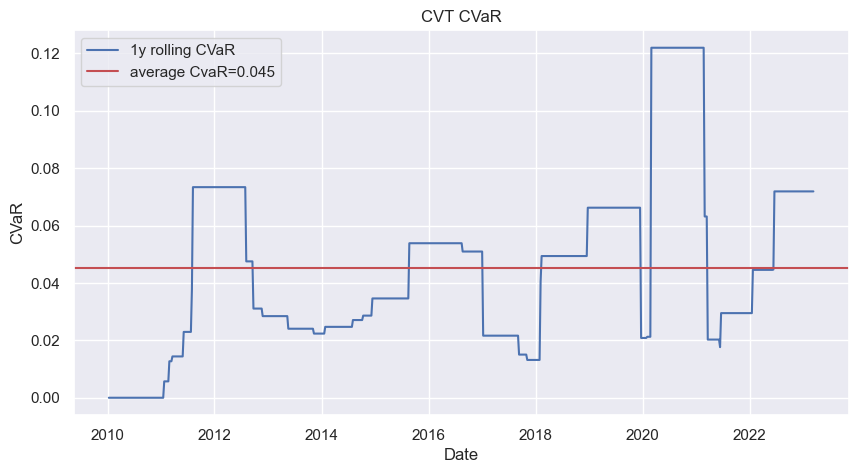

In [18]:
# CVaR 타게팅 적용 시 포트폴리오의 1년 롤링 CVaR 계산
cvt_rolling_CVaR = -cvt_rets.rolling(52).apply(calculate_CVaR).fillna(0)

# 시계열 포트폴리오 CVaR 시각화
plt.figure(figsize=(10, 5))
plt.plot(cvt_rolling_CVaR, label='1y rolling CVaR')
plt.axhline(cvt_rolling_CVaR.mean(), color='r', label=f'average CvaR={np.round(cvt_rolling_CVaR.mean(), 3)}')

plt.title('CVT CVaR')
plt.xlabel('Date')
plt.ylabel('CVaR')
plt.legend()
plt.show()